<font size="4">

## Práctica 1: Clasificación de Imágenes usando Transfer Learning

Se adjunta como anexo el conjunto de datos Skin-Cancer. Dicho conjunto de datos
contiene imágenes de diversos tumores cutáneos divididos en dos clases: Maligno o Benigno.
Se busca desarrollar un algoritmo que clasifique los tumores del conjunto de datos
proporcionado en Malignos mediante redes neuronales en PyTorch. Se pide partir de un
algoritmo de Deep Learning preentrenado en una topología ya disponible (VGG,
ResNet, etc.) y aplicar Transfer Learning.

In [1]:
import kagglehub
from sympy.printing.pytorch import torch

# Download latest version
#path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

#print("Path to dataset files:", path)

100%|██████████| 325M/325M [00:15<00:00, 22.4MB/s] 

Extracting model files...


Path to dataset files: /Users/joseluismezquitajimenez/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


<font size="4">

Una vez ya tenemos descargado el dataset de imágenes, procedemos a importar las librerías

In [83]:
# importamos librerias
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm


<font size="4">

A continuación vamos a definir el device que será el lugar de procesamiento al que enviaremos los datos. En este caso, usaremos mps, ya que este ordenador es un MacBook Pro M3, mientras que los ordenadores windows usan cuda como gráfica.

In [84]:
# definimos el device al que le enviaremos los datos y el modelo
device = torch.device("mps" if  torch.mps.is_available() else "cpu")
print(device)

mps


<font size="4">

Una vez ya tenemos el dataset descargado con las imágenes en su correspondiente carpeta, debemos transformarlo a tensor, que es la estructura que se utilizan en las redes neuronales convolucionales. 

Para ello, vamos a usar la funcion transforms.Compose(), con la que estableceremos una especie de pipeline, en donde, haremos todas las transformaciones al dataset (toTensor, resize...)

In [85]:
# realizamos transformaciones
transformaciones = transforms.Compose([transforms.ToTensor(), # convertimos a tensor
                                       transforms.Resize((224, 224)), # ajustamos tamaño a 224x224
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], # normalizamos con media y deviacion
                                                            std=[0.229, 0.224, 0.225]),
                                       ])

<font size="4">

Una vez ya tenemos establecida la transformación que se le va a aplicar a las imagenes, vamos a definir el dataloader de entrenamiento
y de test, aplicándoles la transformación. Además, indicaremos el batch para el conjunto de entrenamiento.

In [96]:
# lectura de imagenes de un dataset
dataset_train = datasets.ImageFolder("dataset/train", transform=transformaciones)
dataset_test = datasets.ImageFolder("dataset/test", transform=transformaciones)

len(dataset_train), len(dataset_test)

(2637, 660)

<font size="4">

Ya hemos leido los directorios y las imágenes se encuentran almacenadas junto a su valor en dataset_train y dataset_test. A continuación mostramos el formato que tiene una tupla (imagen_tensor, valor).

Como podemos ver, se trata de una imagen de 3 canales RGB (lo que significa que es una imagen de color) y su etiqueta.

In [87]:
imagen, valor = dataset_train[0]
imagen.shape, valor

(torch.Size([3, 224, 224]), 0)

In [88]:
# recuento de cada etiqueta
v1 = 0
v0 = 0
for imagen, valor in dataset_train:
    if valor == 1:
        v1 += 1
    else:
        v0 += 1
print(f"valor 1: {v1}, valor 0: {v0}, total = {v1+v0}")

valor 1: 1197, valor 0: 1440, total = 2637


<font size="4">

Preparamos el dataset aplicando la función Dataloader, la cual nos va a permitir añadir una dimensión más al tensor. Esta nueva dimensión hace referencia al tamaño del batch.

In [89]:
dataset_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataset_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

<font size="4">

Ya tenemos todo preparado, ahora es el momento de seleccionar el modelo pre-entrenado. En nuestro caso, vamos a utilizar el modelo conocido como ResNet18. 

**ResNet18** es una arquitectura de red neuronal convolucional diseñada para tareas de visión por computadora, como clasificación de imágenes, que forma parte de la familia de las redes residuales (*Residual Networks*). Su principal innovación son los **bloques residuales**, que utilizan *skip connections* (conexiones de atajo) para permitir que la información fluya directamente entre capas no contiguas, lo cual facilita el entrenamiento de redes más profundas al evitar el problema del *vanishing gradient*. ResNet18 tiene **18 capas con pesos entrenables**, incluyendo convoluciones y una única capa densa final, lo que la hace compacta y eficiente. Es especialmente útil cuando se entrena con datasets de tamaño moderado o cuando se hace *transfer learning* usando pesos preentrenados en grandes conjuntos como ImageNet.

A continuación, se muestra una imagen sobre la arquitectura que tiene:
![Resnet](Original-ResNet-18-Architecture.png)


En el siguiente fragmento de código, vamos a crearnos una instancia del modelo pre-entrenado, en donde, congelaremos los pesos de las capas para aprovecharnos de esa ventaja. Después vamos a modificar la salida ajustándola a nuestro problema.

Para ello, nuestra red neuronal tendra N entradas, luego pasará por 3 capas ocultas de 128, 64 y 16 neuronas y, terminando por la capa de salida formada por 2 únicas neuronas.

In [90]:
# obtenemos los pesos
pesos = ResNet18_Weights.DEFAULT
# creamos instancia del modelo
modelo = torchvision.models.resnet18(weights=pesos)

# congelamos las capas convolucionales para no modificar pesos en el train
for parametro in modelo.parameters():
    parametro.requires_grad = False

# modificamos la salida ajustandola a nuestro problema (output=2)
modelo.fc = nn.Sequential(
    nn.Linear(modelo.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16, 2),
)

# enciamos modelo al device
modelo = modelo.to(device)

print(f"Información del modelo\n {modelo}")

Información del modelo
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

<font size="4">

Ya tenemos todo preparado, solo nos queda entrenar el modelo. Para ello, antes de nada, debemos definir la función de pérdida, la función de optimización, que es la encargada de ajustar los pesos.

Después de esto, entrenamos el modelo.

In [91]:
# funcion de coste
funcion_perdida = nn.CrossEntropyLoss()

# funcion de optimizacion
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.001)

# Inicializar listas para guardar métricas
epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Inicializar listas para guardar métricas
for epoch in range(epochs):
    modelo.train()
    running_loss, correct, total = 0.0, 0, 0
    bar = tqdm(dataset_train, desc=f"Epoch {epoch+1}")

    for images, labels in bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = modelo(images)
        loss = funcion_perdida(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        bar.set_postfix(loss=running_loss / len(dataset_train))

    train_losses.append(running_loss / len(dataset_train))
    train_accuracies.append(correct / total)

    # Evaluación en test dentro del bucle para guardar cada época
    modelo.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataset_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            loss = funcion_perdida(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_test += predicted.eq(labels).sum().item()
            total_test += labels.size(0)

    test_losses.append(test_loss / len(dataset_test))
    test_accuracies.append(correct_test / total_test)

    print(f"Epoch {epoch+1} completada.")
    print(f"  Train -> Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f}")
    print(f"  Test  -> Loss: {test_losses[-1]:.4f}, Acc: {test_accuracies[-1]:.4f}")


Epoch 1: 100%|██████████| 42/42 [00:10<00:00,  4.17it/s, loss=0.589]


Epoch 1 completada.
  Train -> Loss: 0.5890, Acc: 0.6701
  Test  -> Loss: 0.4107, Acc: 0.8121


Epoch 2: 100%|██████████| 42/42 [00:10<00:00,  4.12it/s, loss=0.479]


Epoch 2 completada.
  Train -> Loss: 0.4793, Acc: 0.7812
  Test  -> Loss: 0.3889, Acc: 0.8167


Epoch 3: 100%|██████████| 42/42 [00:09<00:00,  4.34it/s, loss=0.412] 


Epoch 3 completada.
  Train -> Loss: 0.4119, Acc: 0.8244
  Test  -> Loss: 0.3614, Acc: 0.8379


Epoch 4: 100%|██████████| 42/42 [00:09<00:00,  4.44it/s, loss=0.382] 


Epoch 4 completada.
  Train -> Loss: 0.3823, Acc: 0.8362
  Test  -> Loss: 0.3595, Acc: 0.8197


Epoch 5: 100%|██████████| 42/42 [00:09<00:00,  4.43it/s, loss=0.373] 


Epoch 5 completada.
  Train -> Loss: 0.3728, Acc: 0.8271
  Test  -> Loss: 0.3339, Acc: 0.8424


Epoch 6: 100%|██████████| 42/42 [00:09<00:00,  4.33it/s, loss=0.339] 


Epoch 6 completada.
  Train -> Loss: 0.3391, Acc: 0.8502
  Test  -> Loss: 0.3404, Acc: 0.8439


Epoch 7: 100%|██████████| 42/42 [00:09<00:00,  4.27it/s, loss=0.309] 


Epoch 7 completada.
  Train -> Loss: 0.3095, Acc: 0.8567
  Test  -> Loss: 0.3264, Acc: 0.8424


Epoch 8: 100%|██████████| 42/42 [00:09<00:00,  4.64it/s, loss=0.32]  


Epoch 8 completada.
  Train -> Loss: 0.3204, Acc: 0.8574
  Test  -> Loss: 0.3190, Acc: 0.8485


Epoch 9: 100%|██████████| 42/42 [00:09<00:00,  4.55it/s, loss=0.303] 


Epoch 9 completada.
  Train -> Loss: 0.3032, Acc: 0.8631
  Test  -> Loss: 0.3177, Acc: 0.8439


Epoch 10: 100%|██████████| 42/42 [00:09<00:00,  4.37it/s, loss=0.328] 


Epoch 10 completada.
  Train -> Loss: 0.3282, Acc: 0.8464
  Test  -> Loss: 0.3454, Acc: 0.8167


<font size="4">

Una vez ya está entrenado y evaluado el modelo, pasamos a las métricas. Para ello, procederemos a dibujar la curva de pérdida, de precisión y la matriz de confusión.

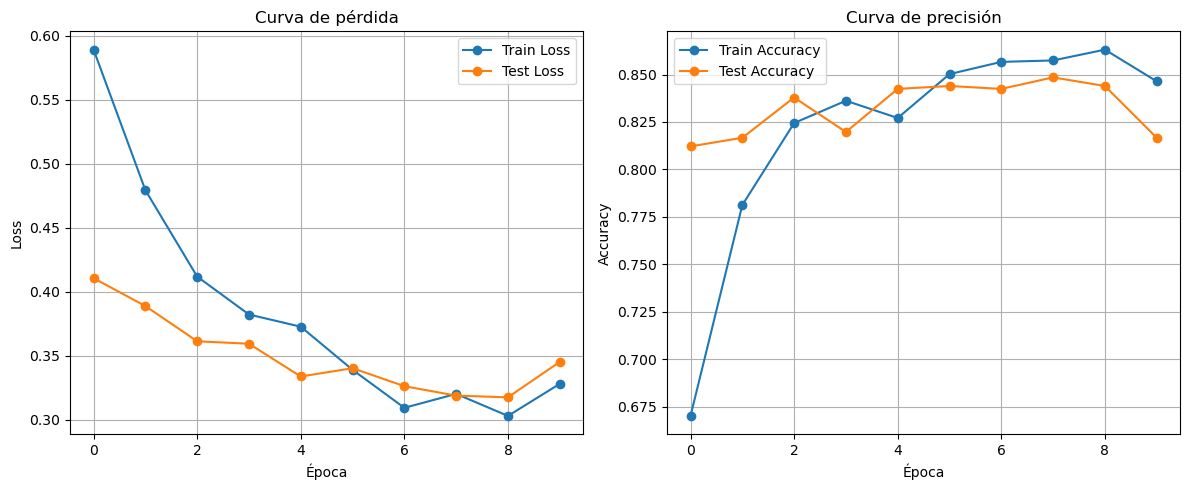

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Curva de pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='o')
plt.title("Curva de pérdida")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Curva de precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.title("Curva de precisión")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

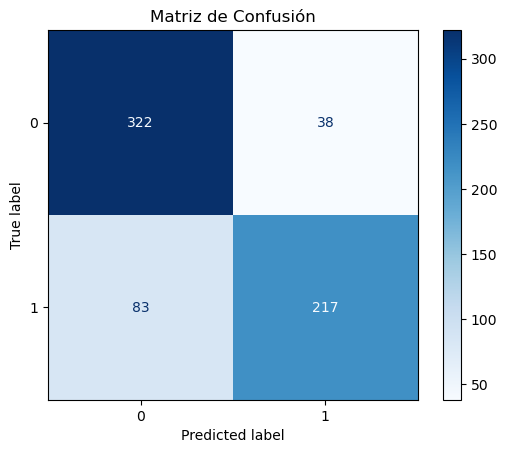

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

modelo.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in dataset_test:
        images = images.to(device)
        outputs = modelo(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()


<font size="4">

Como podemos observar en las gráficas de pérdida y de precisión, conforme van ejecutándose las épocas, los resultados van mejorando. Vemos que la pérdida va reduciéndose y la precisión de los aciertos va mejorando de manera notable.

Por otro lado, podemos ver, mediante la matriz de confusión, que la precisión de acierto es muy buena, tanto para cuando se trata de tumor maligno como el contrario. El porcentaje de acierto tanto para una clase como para la otra es de 539 sobre 660, lo que viene a ser una precisión del 81,67% de aciertos durante la etapa de evaluación con el conjunto de test.